In [1]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [2]:
from   PIL import Image
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import torch

from   data import MnistConfig, MnistDataset, loader
from   models import LeNet5AE, DPCCA, MAE

In [3]:
cfg = MnistConfig()

In [4]:
# path = '/Users/gwg/dmcm/experiments/20190110_mnist_viz/'\
#        'mnist_mode-dpcca_batch_size-128_seed-0_latent_dim-2_lr-0.0001_l1_coef-0.0_private_z-1/model.pt'
path = 'experiments/20190228_mnist_good/model.pt'

state = torch.load(path, map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=2, use_gene_net=True)
model.load_state_dict(state)

In [5]:
path = 'experiments/20190306_mnist_ae/'\
       'mnist_mode-ae_seed-0_latent_dim-2_lr-0.001_l1_coef-0.0_em_iters-1/'\
       'model.pt'

state = torch.load(path, map_location={'cuda:0': 'cpu'})
lenet5 = LeNet5AE(cfg)
lenet5.load_state_dict(state)

path = 'experiments/20190307_5x_mae_mnist_baseline/'\
       'mnist_mode-mae_seed-0_latent_dim-2_lr-0.001_l1_coef-0.0_em_iters-1/'\
       'model.pt'
state = torch.load(path, map_location={'cuda:0': 'cpu'})
mae = MAE(cfg)
mae.load_state_dict(state)

In [6]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    cv_pct=0.1)
dataset = train_loader.dataset

In [12]:
inds = train_loader.sampler.indices
n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)

j = 0
for idx in inds:
    lab = dataset.labels[idx]
    x1, x2 = dataset[idx]
    X1[j] = x1
    X2[j] = x2
    labels[j] = lab
    j += 1

# This dataset is too big to visualize. Let's cut out some samples at random.
inds = np.arange(0, n)
np.random.shuffle(inds)
inds = inds[:1000]

X1     = X1[inds]
X2     = X2[inds]
labels = labels[inds]
    
Zs = model.estimate_z_given_x([X1, X2], threshold=None).detach()

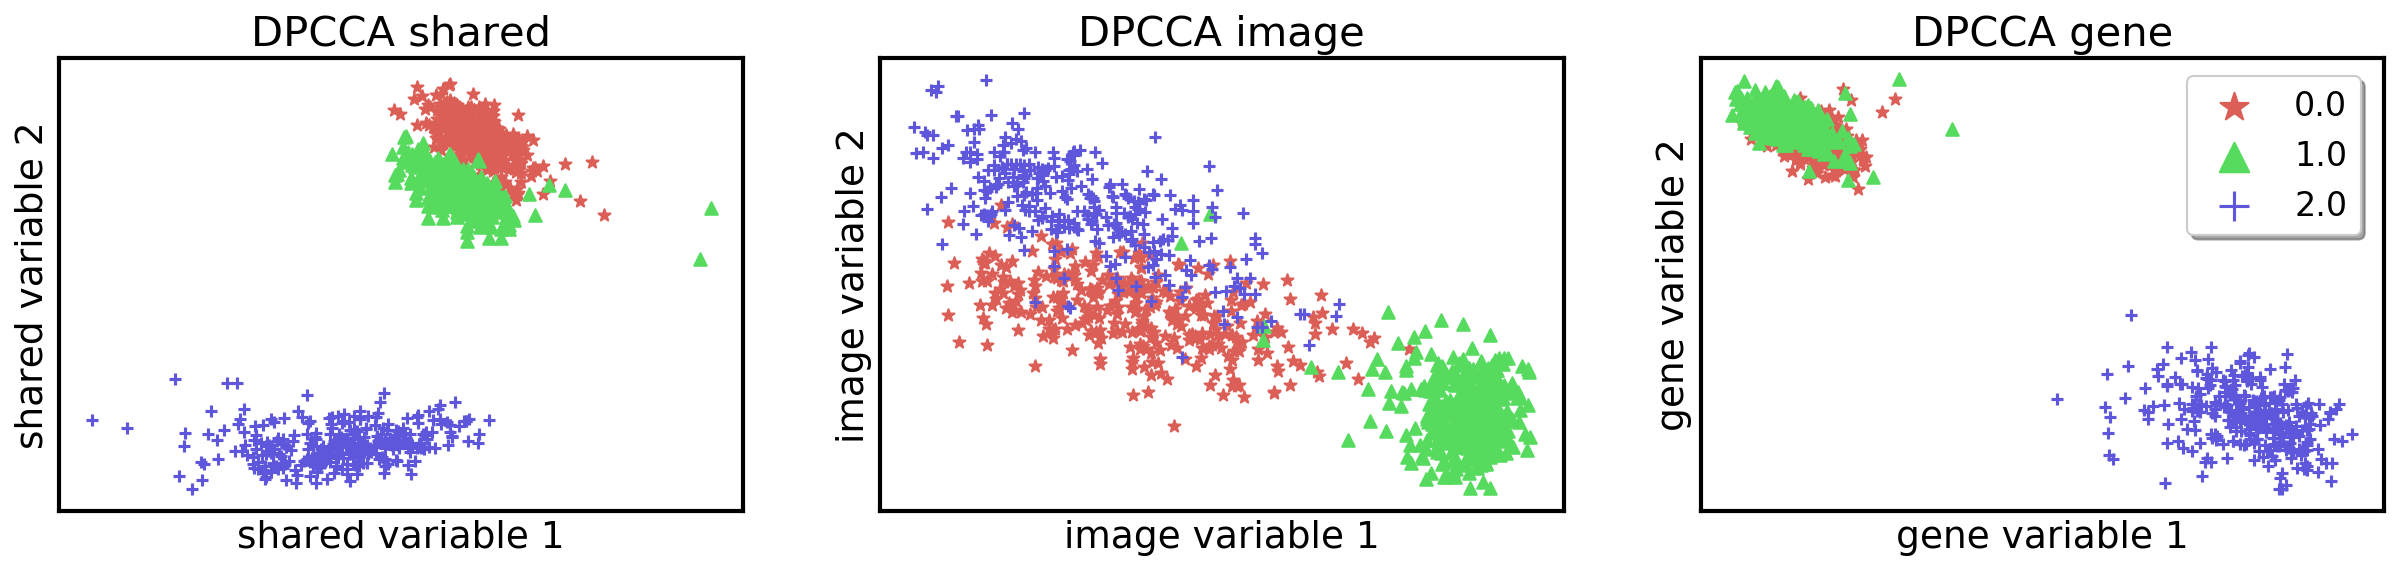

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=150)

uniq_labels = np.unique(labels)
sns.set_palette('hls', 3)
colors = sns.color_palette()

for (i,j), ax, view in zip([(0, 2), (2, 4), (4, 6)],
                            axes.flat,
                            ['shared', 'image', 'gene']):
    Zs_view = Zs[:, i:j]
    for i, col, marker in zip(uniq_labels, colors, ['*', '^', '+']):
        inds = labels.numpy() == i
        data = Zs_view.numpy()[inds]
        ax.scatter(data[:, 0], data[:, 1], label=i, marker=marker)
        ax.set_title('DPCCA ' + view, fontsize=20)
        ax.set_xlabel('%s variable 1' % view, fontsize=18)
        ax.set_ylabel('%s variable 2' % view, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

handles, axlabels = ax.get_legend_handles_labels()
lgnd = fig.legend(handles, axlabels, loc='lower center', bbox_to_anchor=(0.758, 0.53),
                  fontsize=16, shadow=True)
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]
lgnd.legendHandles[2]._sizes = [200]

In [15]:
y1    = mae.image_net.encode(X1)
y2    = mae.genes_net.encode(X2)
y     = torch.cat([y1, y2], dim=1)
mae_z = mae.enc(y).detach().numpy()

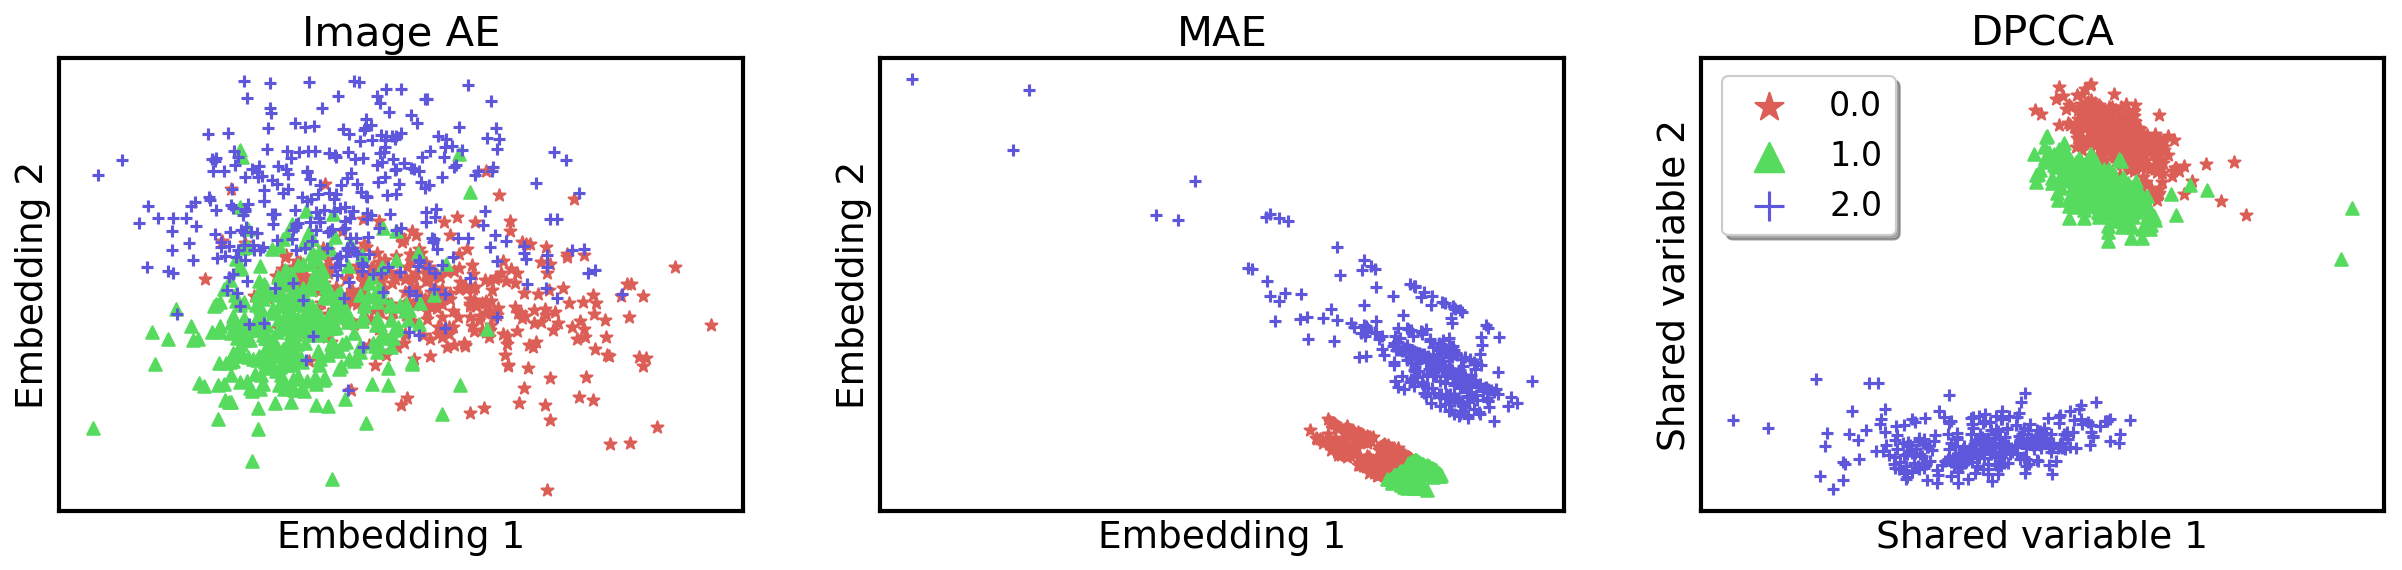

In [28]:
my_Z  = Zs[:, 0:2].detach().numpy()
ae_Z  = lenet5.encode(X1).detach().numpy()
        
fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=150)

uniq_labels = np.unique(labels)
sns.set_palette('hls', 3)
colors = sns.color_palette()

plot_Zs  = [ae_Z, mae_z, my_Z]
titles   = ['Image AE', 'MAE', 'DPCCA']
xylabels = ['Embedding', 'Embedding', 'Shared variable']

for ax, Z, title, xylab in zip(axes.flat, plot_Zs, titles, xylabels):
    for i, col, marker in zip(uniq_labels, colors, ['*', '^', '+']):
        inds = labels.numpy() == i
        data = Z[inds]
        if title == 'DPCCA':
            ax.scatter(data[:, 0], data[:, 1], label=i, marker=marker)
        else:
            ax.scatter(data[:, 0], data[:, 1], marker=marker)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('%s 1' % xylab, fontsize=18)
        ax.set_ylabel('%s 2' % xylab, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
        
# handles, plt_labels = ax.get_legend_handles_labels()
# lgd = fig.legend(handles, plt_labels, loc='lower center', ncol=3,
#                  shadow=True, fontsize=16)
# fig.subplots_adjust(bottom=0.3)
handles, axlabels = ax.get_legend_handles_labels()
lgnd = fig.legend(handles, axlabels, loc='lower center', bbox_to_anchor=(0.603, 0.53),
                  fontsize=16, shadow=True)
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]
lgnd.legendHandles[2]._sizes = [200]

In [12]:
from scipy.stats import wilcoxon

wilcoxon_results = []
for factor_idx in [0, 2, 4]:
    for digit in [0, 1, 2]:
        inds = (labels == digit).numpy().astype(bool)
        Zk = Zs[:, factor_idx].numpy()
        Z_by_digit = Zk[inds]
        result = wilcoxon(Z_by_digit)
        print(len(Z_by_digit), result.statistic)
        wilcoxon_results.append(result.statistic)

295 118.0
366 2323.0
339 1643.0
295 3147.0
366 8.0
339 651.0
295 0.0
366 0.0
339 0.0


0
2
4


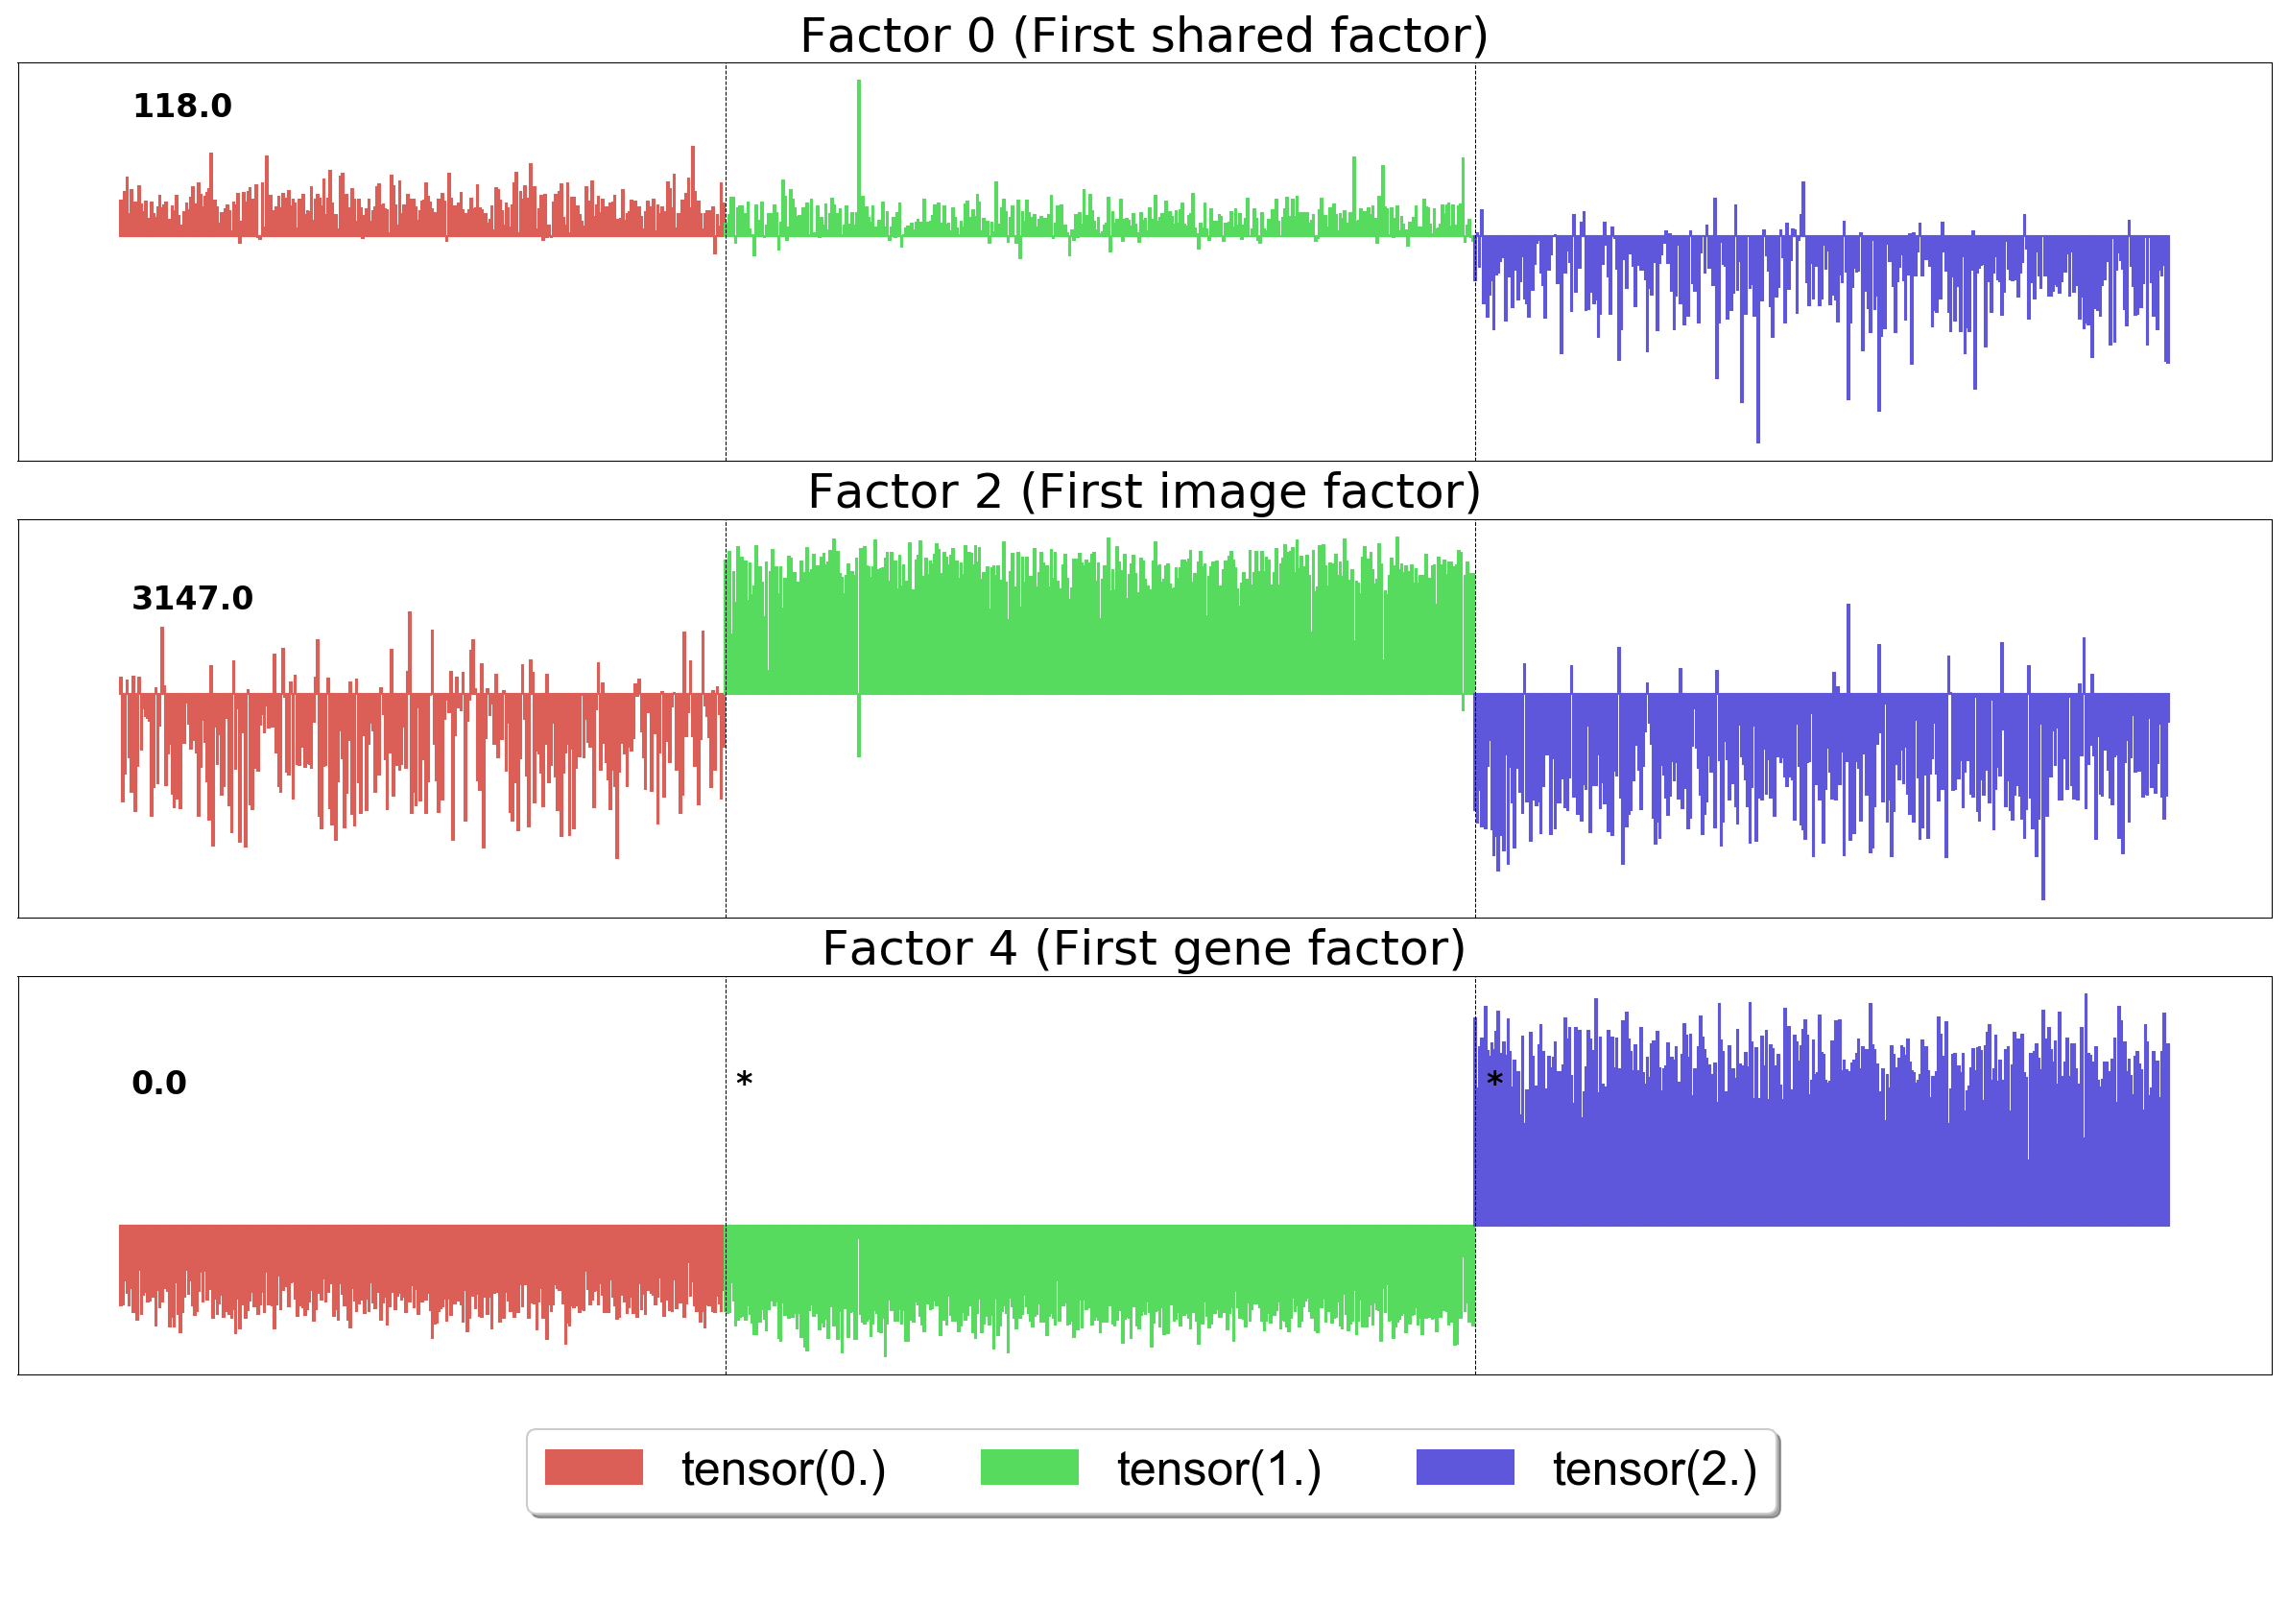

In [13]:
import copy

wilcoxon_results_copy = copy.deepcopy(wilcoxon_results)

factors   = [0, 2, 4]
fig, axes = plt.subplots(len(factors), 1, dpi=150)
fig.set_size_inches(16, 12)

inds          = np.argsort(labels)
labels_sorted = labels[inds].numpy()
digs_sorted   = labels[inds]
Zs_sorted     = Zs.numpy()[inds]

sns.set_palette('hls', 3)
colors = sns.color_palette()
np.random.shuffle(colors)
titles = ['First shared factor', 'First image factor', 'First gene factor']

WILCOXON_OFFSET = 5

for ax, factor_idx, title in zip(axes.flat, factors, titles):
    print(factor_idx)
    
    stat = wilcoxon_results_copy.pop(0)
    ax.annotate(stat, xy=(WILCOXON_OFFSET, 0.1), fontsize=16, weight='bold')

    zk = Zs_sorted[:, factor_idx]
    curr_label = labels_sorted[0]
    j = 0
    curr_color = colors[j]

    labels_added = []

    for i, z in enumerate(Zs_sorted):
        if curr_label != labels_sorted[i]:
            curr_label = labels_sorted[i]
            j += 1
            curr_color = colors[j]
            ax.axvline(x=i, color='k', linestyle='--', linewidth=0.5)
            stat = wilcoxon_results_copy.pop(0)
            if stat == 0:
                ax.annotate('*', xy=(i+WILCOXON_OFFSET, 0.1), fontsize=16, weight='bold')
        
        curr_tiss = digs_sorted[i]
        if curr_tiss not in labels_added:
            labels_added.append(curr_tiss)
            ax.bar(i, zk[i], label=curr_tiss, color=curr_color, edgecolor=curr_color)
        else:
            ax.bar(i, zk[i], color=curr_color, edgecolor=curr_color)

    box = ax.get_position()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Factor %s (%s)' % (factor_idx, title), fontsize=24)

plt.rc('axes', linewidth=2)
plt.rcParams['font.family'] = 'arial'

plt.tight_layout()
handles, plt_labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, plt_labels, loc='lower center', ncol=6,
                 shadow=True, bbox_to_anchor=(0.5, 0.05), fontsize=24)
fig.subplots_adjust(bottom=0.2)